In [72]:
import pandas as pd
from lib import create_portfolio
import numpy as np
import scipy.optimize as sp
import matplotlib.pyplot as plt
import scipy as si
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [73]:
DAYS = 252
RISK_FREE = 0.045 / DAYS

In [74]:
data = pd.read_csv("data.csv", index_col=0, header=[0, 1])

In [75]:
# Using Daily Change in price
log_returns = np.log(data["Close"] / data["Close"].shift(1))

In [76]:
def downside_var(returns, mar=0.05,periods=252):
    downside = returns[returns < mar/periods]

    downside = downside.fillna(0)
    downside_diff = downside - mar
    downside_var = np.mean(downside_diff ** 2)
    return downside_var

In [ ]:
def semicovariance(returns):
    downside = np.minimum(returns, 0)
    np.fill_diagonal(returns.corr().values, returns.apply(downside_var))
    return downside

In [282]:
# Using Daily Change in price
log_returns = np.log(data["Close"] / data["Close"].shift(1))

# Create Co-variance table, correlation including upside
covariance_table = log_returns.cov()
np.fill_diagonal(covariance_table.values, log_returns.apply(downside_var))


In [284]:
semicovariance(log_returns)

Ticker,AAPL,GLD,KO,META,MS,MSFT,TSM
Date,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.009770,0.000000,-0.005471,-0.005305,-0.016273,-0.012530,-0.033534
2020-01-06,0.000000,0.000000,-0.000366,0.000000,-0.003522,0.000000,-0.011607
2020-01-07,-0.004714,0.000000,-0.007712,0.000000,-0.001962,-0.009160,0.000000
2020-01-08,0.000000,-0.007530,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2024-12-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004980
2024-12-26,0.000000,0.000000,-0.004306,-0.007266,0.000000,-0.002781,-0.015975
2024-12-27,-0.013331,-0.006894,-0.001920,-0.005885,-0.009969,-0.017453,-0.007067


In [285]:
x_0 = np.array([1./len(log_returns.columns)] * len(log_returns.columns))
args = (log_returns.mean(), covariance_table)
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bound = (0,1)
bounds = [bound for _ in range(len(log_returns.columns))]

In [286]:
def opt_min_risk(weights, returns, co_variance_table):
    return create_portfolio(returns, weights, co_variance_table)[1]


def opt_min_return(weights, returns, co_variance_table):
    return create_portfolio(returns, weights, co_variance_table)[0]

def opt_max_return(weights, returns, co_variance_table):
    return -create_portfolio(returns, weights, co_variance_table)[0]


def opt_max_sortino(weights, returns, co_variance_table):
    returns, std = create_portfolio(returns, weights, co_variance_table)
    sharpe = (returns - RISK_FREE) / std
    return -sharpe

In [287]:
lowest_risk = sp.minimize(opt_min_risk, x_0, args=args, constraints=constraints, bounds=bounds)
min_return = sp.minimize(opt_min_return, x_0, args=args, constraints=constraints, bounds=bounds)
max_return = sp.minimize(opt_max_return, x_0, args=args, constraints=constraints, bounds=bounds)
max_sortino = sp.minimize(opt_max_sortino, x_0, args=args, constraints=constraints, bounds=bounds)

In [288]:
def efficient_optimisation(mean_returns, target_return, covariance_table):
    """
    Calculates lowest risk for a given target return
    """
    x_0 = np.array([1./len(mean_returns)] * len(mean_returns))
    args = (mean_returns, covariance_table)
    bound = (0,1)
    bounds = tuple([bound for _ in range(len(mean_returns))])

    constraints = ({"type": "eq", "fun": lambda x: create_portfolio(mean_returns, x, covariance_table)[0] - target_return},
                  {"type": "eq", "fun": lambda x: np.sum(x) - 1})
    
    result = sp.minimize(opt_min_risk, x_0, args, bounds=bounds, constraints=constraints)
    return result

In [289]:
mean_returns = log_returns.mean().values
covariance_table = log_returns.cov().values
np.fill_diagonal(covariance_table, log_returns.apply(downside_var))

# target_returns = np.linspace(create_portfolio(log_returns.mean(), lowest_risk["x"], covariance_table)[1], create_portfolio(log_returns.mean(), max_sharpe["x"], covariance_table)[1], 25) # Top half of efficient frontier
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50) # Includes bottom half of efficient frontier

In [290]:
risk_min_list = []
for target in target_returns:
    res = efficient_optimisation(mean_returns, target, covariance_table)
    if res.success:
        risk_min_list.append(res.fun)

In [291]:
max_sharpe_ratio_return, max_sharpe_ratio_std = create_portfolio(mean_returns, max_sortino.x, covariance_table)

sharpe = (((max_sharpe_ratio_return-RISK_FREE) * DAYS) / (max_sharpe_ratio_std * np.sqrt(DAYS))) 

capital_market_line_x = np.linspace(0, (max_sharpe_ratio_std * np.sqrt(DAYS)) * 1.5, 50)

capital_market_line_y =  (sharpe * capital_market_line_x) + RISK_FREE*DAYS


# Graphing

Text(0.5, 1.0, 'Post Modern Portfolio Theory')

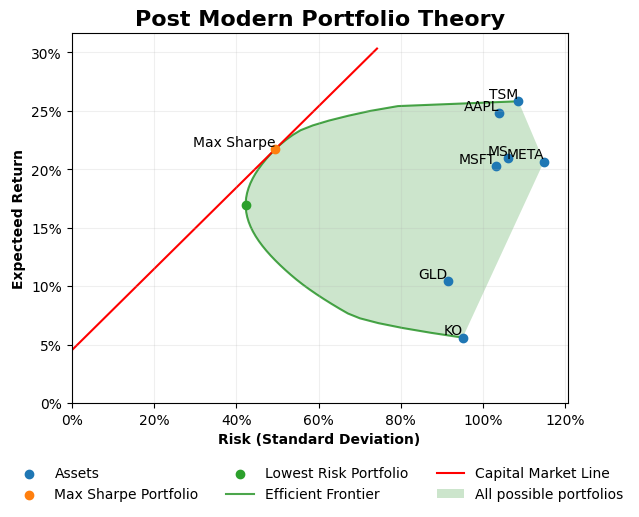

In [292]:
fig, ax = plt.subplots()

ax.scatter(np.sqrt(covariance_table.diagonal()) * np.sqrt(DAYS),
           mean_returns * DAYS,
           label="Assets")

ax.scatter(create_portfolio(mean_returns,max_sortino.x, covariance_table)[1] * np.sqrt(DAYS),
           create_portfolio(mean_returns,max_sortino.x, covariance_table)[0] * DAYS,
           label="Max Sharpe Portfolio")

ax.scatter(create_portfolio(mean_returns,lowest_risk.x, covariance_table)[1] * np.sqrt(DAYS),
           create_portfolio(mean_returns,lowest_risk.x, covariance_table)[0] * DAYS,
           label="Lowest Risk Portfolio")

# ax.text(create_portfolio(mean_returns,lowest_risk.x, covariance_table)[1] * np.sqrt(DAYS),
        # create_portfolio(mean_returns,lowest_risk.x, covariance_table)[0] * DAYS, 
        # "Lowest Risk", 
        # fontdict=
            # {"horizontalalignment":"left", "verticalalignment":'top'})

ax.text(create_portfolio(mean_returns,max_sortino.x, covariance_table)[1] * np.sqrt(DAYS),
        create_portfolio(mean_returns,max_sortino.x, covariance_table)[0] * DAYS, 
        "Max Sharpe", 
        fontdict=
            {"horizontalalignment":"right", "verticalalignment":'bottom'})

ax.plot(np.array(risk_min_list) * np.sqrt(DAYS), target_returns * DAYS, "green", alpha=0.7, zorder=0, label="Efficient Frontier")
ax.plot(capital_market_line_x, capital_market_line_y, "r", zorder=0, label="Capital Market Line")

ax.set_xlabel('Risk (Standard Deviation)', fontweight="bold")
ax.set_ylabel('Expecteed Return', fontweight="bold")

ax.set_ylim(0)
ax.set_xlim(0)

for i, t in enumerate(log_returns.columns):
    ax.text((np.sqrt(covariance_table.diagonal()))[i] * np.sqrt(DAYS),
            mean_returns[i] * DAYS,
            t,
        horizontalalignment='right',
        verticalalignment='bottom')

risk_min_arr = np.array(risk_min_list) * np.sqrt(DAYS)
cov_diag_arr = np.sqrt(np.diag(covariance_table)) * np.sqrt(DAYS)
target_returns_arr = np.array(target_returns) * DAYS
mean_returns_arr = np.array(mean_returns) * DAYS

points = np.column_stack([
    np.append(risk_min_arr, cov_diag_arr),
    np.append(target_returns_arr, mean_returns_arr)
])

hull = si.spatial.ConvexHull(points) 
hull_points = points[hull.vertices]


# for simplex in hull.simplices:
    # ax.plot(points[simplex, 0], points[simplex, 1], 'r-', linewidth=1, zorder=0)

ax.fill(hull_points[:, 0], hull_points[:, 1], 'g', alpha=0.2, zorder=0, label="All possible portfolios")

ax.legend( 
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3,                   
    frameon=False)

ax.xaxis.set_major_formatter(PercentFormatter(1, 0))
ax.yaxis.set_major_formatter(PercentFormatter(1, 0))

ax.grid(True, zorder=0, alpha=0.2)

ax.set_title("Post Modern Portfolio Theory", fontweight="bold", fontsize=16)

# Portfolio Weights

In [293]:
sharpe_weights = {x: round(y,4) for x,y in zip(log_returns.columns, max_sortino.x)}
sharpe_weights = sorted(sharpe_weights.items(), key=lambda x: x[1], reverse=True)

for ticker, weight in sharpe_weights:
    print(f"{ticker: <5} : {weight:.2%}")

AAPL  : 22.39%
TSM   : 22.35%
MS    : 16.79%
MSFT  : 16.15%
META  : 12.60%
GLD   : 9.71%
KO    : 0.00%


In [294]:
low_risk_weights = {x: round(y,4) for x,y in zip(log_returns.columns, lowest_risk.x)}
low_risk_weights = sorted(low_risk_weights.items(), key=lambda x: x[1], reverse=True)

for ticker, weight in low_risk_weights:
    print(f"{ticker: <5} : {weight:.2%}")

GLD   : 20.79%
KO    : 17.94%
MSFT  : 13.21%
AAPL  : 12.99%
MS    : 12.82%
TSM   : 12.03%
META  : 10.22%
